In [548]:
# Señal ECG registrada con el BITalino después de la realización de una actividad física

In [ ]:
# Importar librerías

import numpy as np
import matplotlib.pyplot as plt
import re
import pywt

# Cargar archivo ECG

r = open("ecg.txt","r")  
raw_data = r.readlines()[1]
r.close()

In [550]:
# Extraer frecuencia de muestreo con regex
x = re.findall("[0-5][0-9][0-9]\d", raw_data)[0]
Fs = float(x)             # Frecuencia de muestreo
Ts = 1/Fs                 # Periodo de muestreo

print(f"Fs = {Fs} Hz\nTs = {Ts} s")

Fs = 1000.0 Hz
Ts = 0.001 s


In [551]:
# Leer los datos
a_r = np.genfromtxt("ecg.txt", delimiter="\t", skip_header=3)


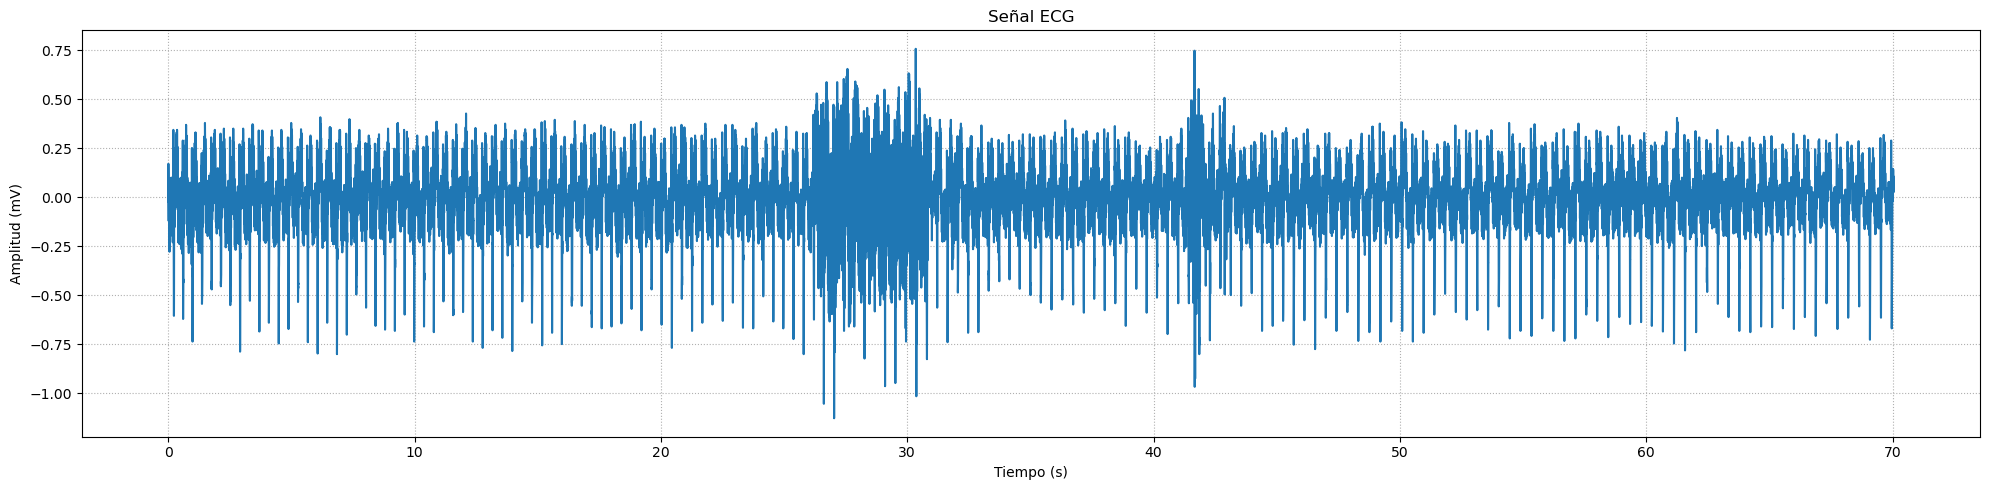

Periodo: 0.40 s → 150.38 bpm


In [552]:
import scipy.signal as signal

bits = 10
volt_range = 3.28  # (-1.64; 1.64) mV

y_1 = (a_r[: ,-2] * volt_range/(2**bits - 1)) 
y_1 = y_1 - np.mean(y_1) 
t_1 = np.arange(0, len(y_1)*Ts, Ts) 

plt.figure(figsize=(20, 5))

plt.plot(t_1, y_1, label="señal") # Señal completa
plt.title("Señal ECG")
plt.grid(linestyle=":")
plt.xlabel("Tiempo (s)") 
plt.ylabel("Amplitud (mV)")
fig = plt.gcf()
fig.set_facecolor('white')
plt.tight_layout()
plt.savefig('ecg.png', transparent=False, )
plt.show()


start_idx = int(28.5*Fs)
end_idx   = int(30.5*Fs)

segment = y_1[start_idx:end_idx]
pk_loc1 = signal.find_peaks(segment, height=0.55, distance=1)[0] # Height = 0.5 para filtrar picos pequeños

# convertir a índice global
pk_loc1_global = pk_loc1 + start_idx

# ahora sí calculamos el periodo real
if len(pk_loc1_global) >= 2:
    T1 = t_1[pk_loc1_global[1]] - t_1[pk_loc1_global[0]]
    bpm1 = (1/T1) * 60
    print(f"Periodo: {T1:.2f} s → {bpm1:.2f} bpm")
else:
    print("No se detectaron suficientes picos en el segmento")




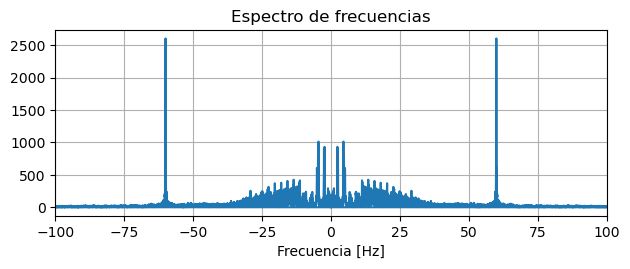

In [553]:
# Calcular la DFT
X = np.fft.fft(y_1)

# Calcular las frecuencias correspondientes
frequencies = np.fft.fftfreq(len(y_1), 1/Fs)

plt.subplot(2, 1, 2)
plt.plot(frequencies, np.abs(X))
plt.title('Espectro de frecuencias')
plt.xlabel('Frecuencia [Hz]')
plt.grid()

# Establecer límites en el eje x
plt.xlim([-100, 100])

plt.tight_layout()
plt.show()

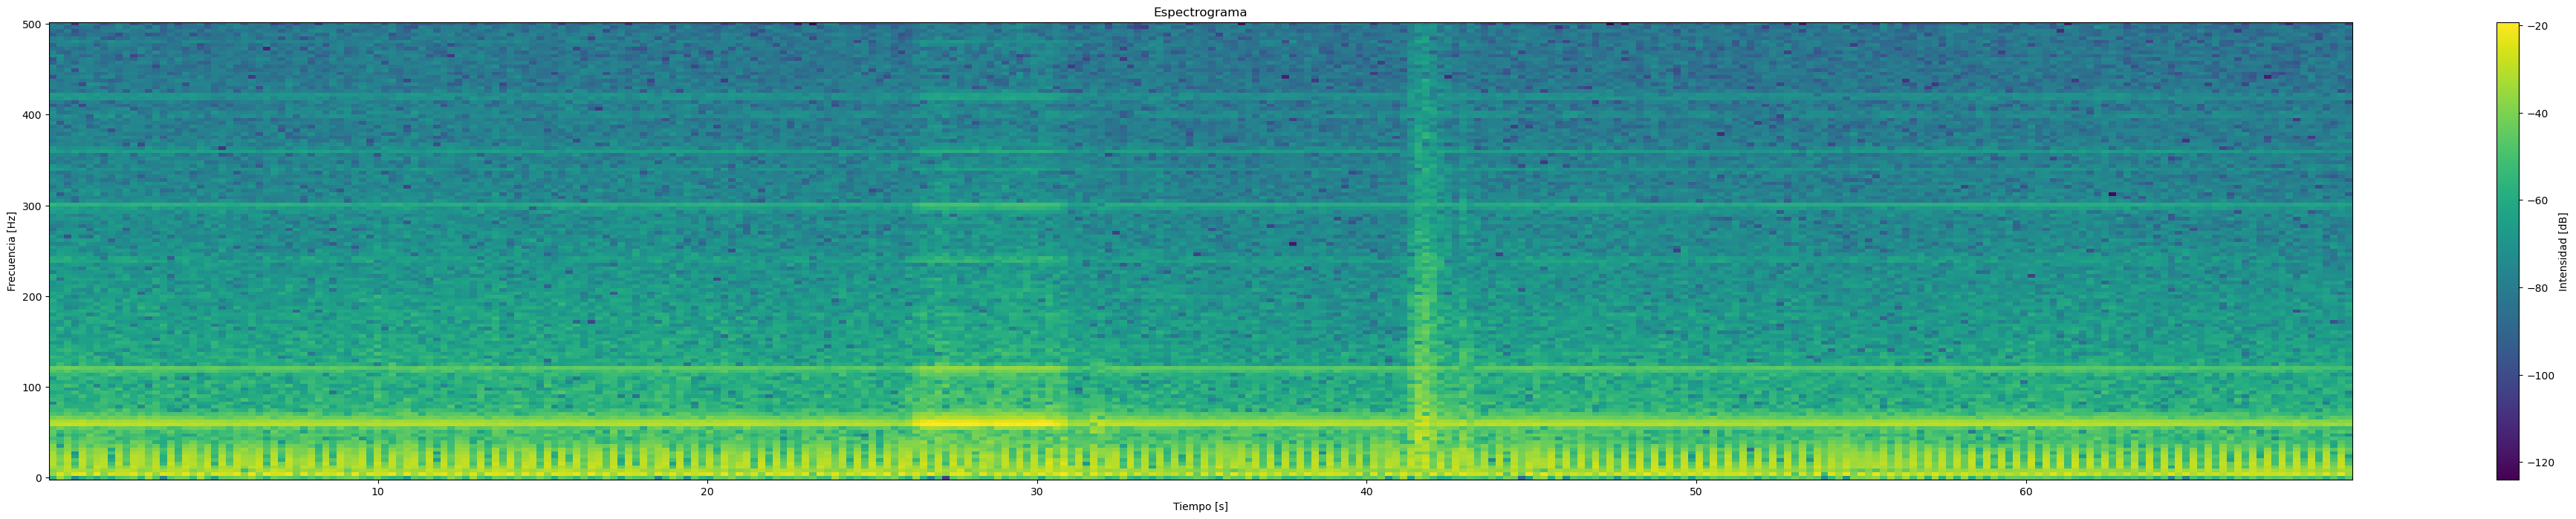

In [554]:
import numpy as np
from scipy.signal import spectrogram
import matplotlib.pyplot as plt

# Calcular la STFT
f, t, Sxx = spectrogram(y_1, Fs)
plt.figure(figsize=(50, 8))

# Visualizar el espectrograma
plt.pcolormesh(t, f, 10 * np.log10(Sxx))  # Usamos escala logarítmica para mejor visualización
plt.ylabel('Frecuencia [Hz]')
plt.xlabel('Tiempo [s]')
plt.title('Espectrograma')
plt.colorbar(label='Intensidad [dB]')
plt.show()

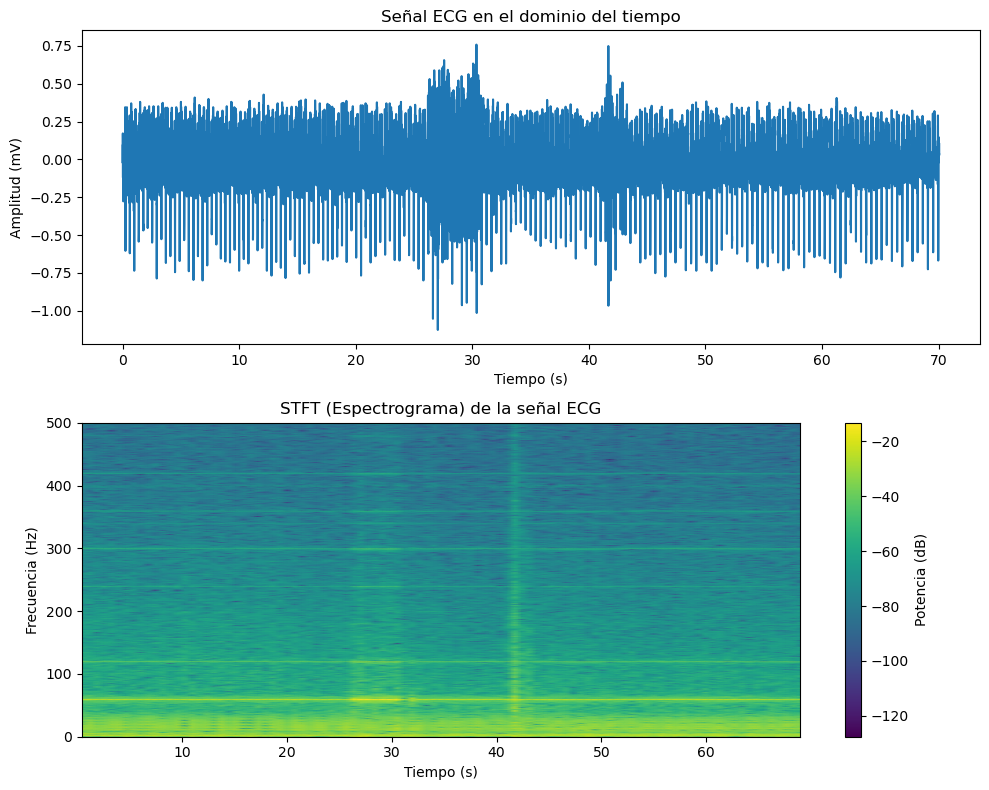

In [555]:
from scipy.signal import spectrogram

# Calcular la STFT de tu señal EMG real
frequencies, times, Sxx = spectrogram(y_1, fs=Fs, nperseg=800)

# Graficar la señal y su espectrograma
plt.figure(figsize=(10, 8))

plt.subplot(2, 1, 1)
plt.plot(t_1, y_1)
plt.title('Señal ECG en el dominio del tiempo')
plt.xlabel('Tiempo (s)')
plt.ylabel('Amplitud (mV)')

plt.subplot(2, 1, 2)
plt.pcolormesh(times, frequencies, 10 * np.log10(Sxx), shading='gouraud')
plt.title('STFT (Espectrograma) de la señal ECG')
plt.ylabel('Frecuencia (Hz)')
plt.xlabel('Tiempo (s)')
plt.colorbar(label='Potencia (dB)')

plt.tight_layout()
plt.show()


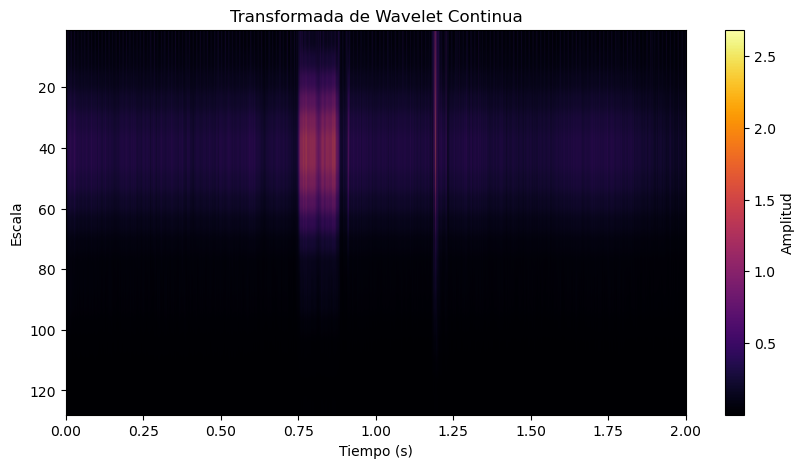

In [556]:
import numpy as np
import matplotlib.pyplot as plt
import pywt

# Definir la escala y la frecuencia central de la wavelet de Morlet
escala = np.arange(1, 20)


# Realizar la transformada de wavelet continua
coeficientes, frecuencias = pywt.cwt(y_1, escala, 'morl', sampling_period=Ts)


# Graficar los coeficientes de la transformada de wavelet
plt.figure(figsize=(10, 5))
plt.imshow(np.abs(coeficientes), extent=[0, 2, 1, 128], aspect='auto', cmap='inferno')
plt.colorbar(label='Amplitud')
plt.title('Transformada de Wavelet Continua')
plt.xlabel('Tiempo (s)')
plt.ylabel('Escala')
plt.gca().invert_yaxis()
plt.show()

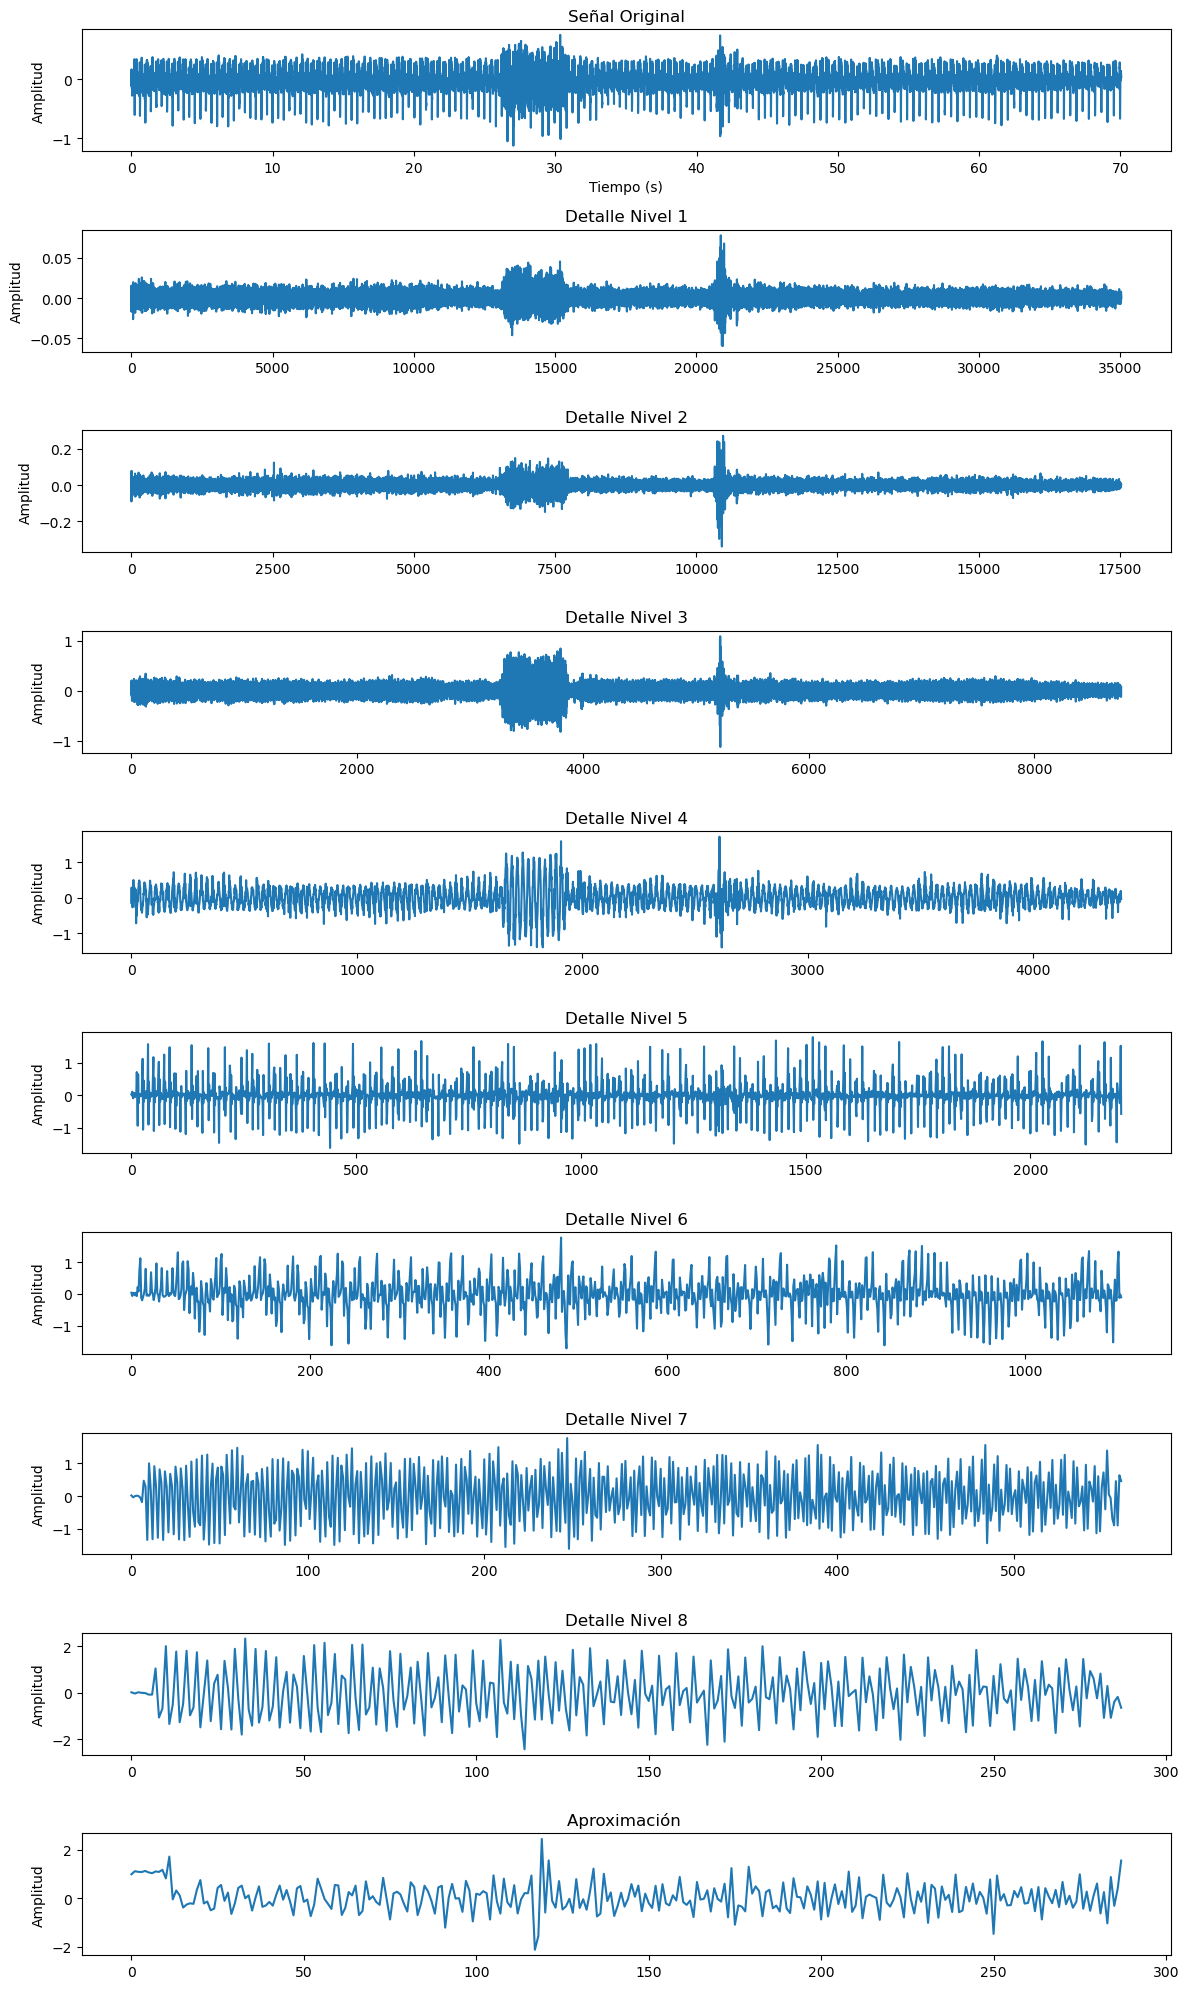

In [557]:
import numpy as np
import matplotlib.pyplot as plt
import pywt

x = y_1 

# Aplicar la DWT
niveles = 8
coeficientes = pywt.wavedec(x, 'db8', level=niveles)
coef_filtrados = coeficientes.copy()

for i in range(1, len(coef_filtrados)):
    coef_filtrados[i] = np.zeros_like(coef_filtrados[i])


# Graficar la señal original y los coeficientes de detalle y de aproximación
plt.figure(figsize=(12, 20))

# Graficar la señal original
plt.subplot(niveles + 2, 1, 1)
plt.plot(t_1, x)
plt.title('Señal Original')
plt.xlabel('Tiempo (s)')
plt.ylabel('Amplitud')

# Graficar los coeficientes de detalle en orden ascendente (del nivel 1 al 8)
for i in range(1, niveles + 1):
    plt.subplot(niveles + 2, 1, i + 1)
    plt.plot(coeficientes[niveles - i + 1])
    plt.title(f'Detalle Nivel {i}')
    plt.ylabel('Amplitud')

# Graficar el coeficiente de aproximación al final
plt.subplot(niveles + 2, 1, niveles + 2)
plt.plot(coeficientes[0])
plt.title(f'Aproximación ')
plt.ylabel('Amplitud')

plt.tight_layout()
plt.show()

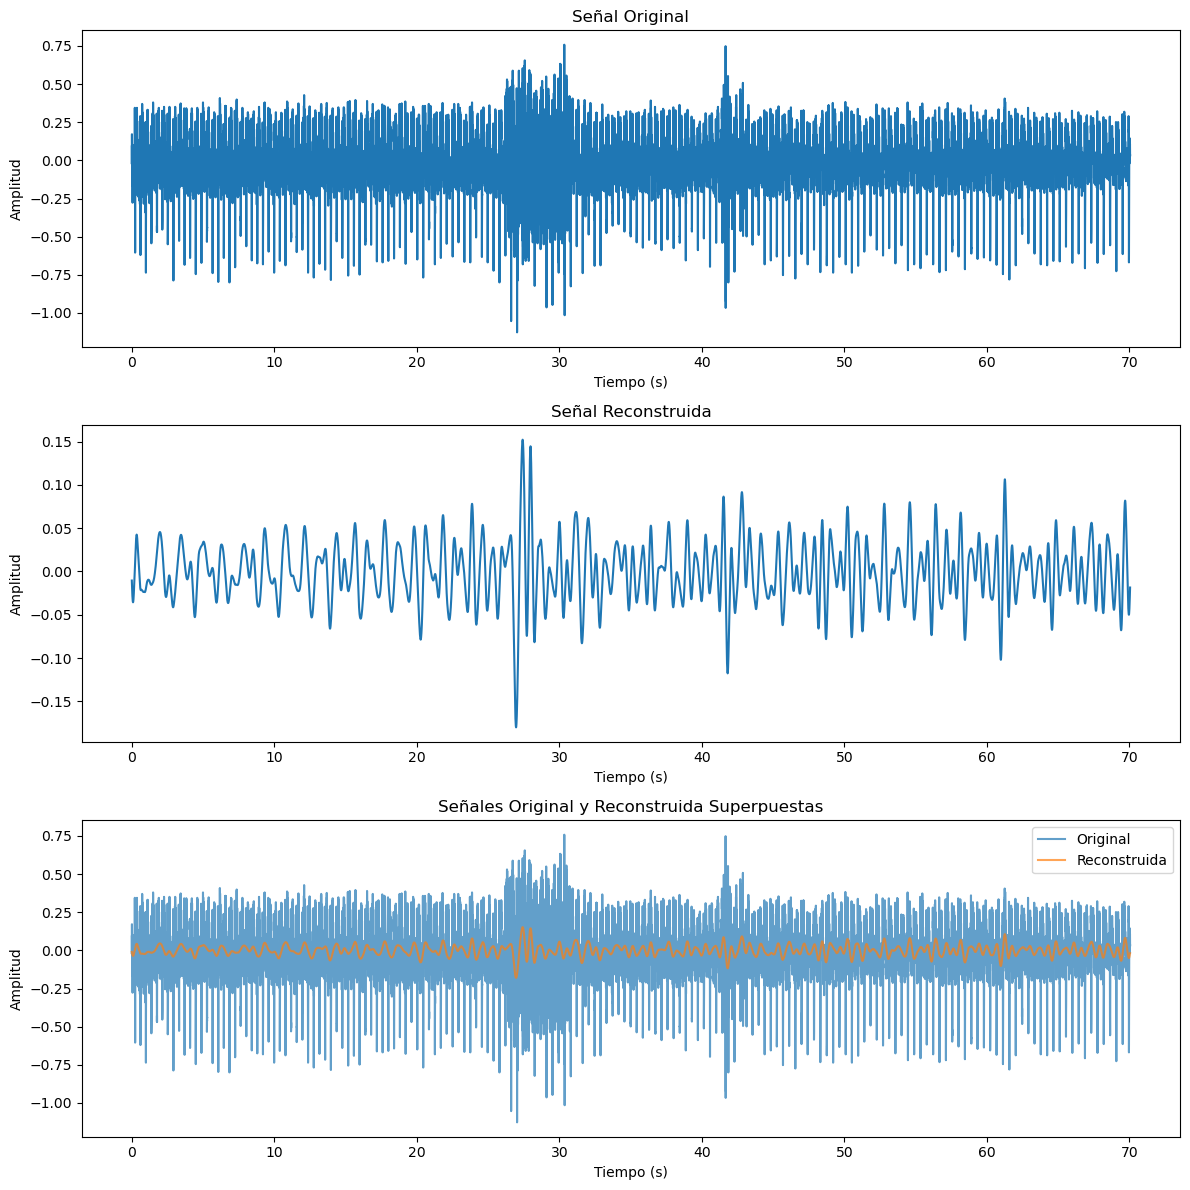

In [558]:
# Reconstruir la señal filtrada/reconstruida
x_rec = pywt.waverec(coef_filtrados, 'db8')
x_rec = x_rec[:len(x)]


# Crear la figura con tres subplots verticales
plt.figure(figsize=(12, 12))

# Graficar la señal original
plt.subplot(3, 1, 1)  
plt.plot(t_1, x)
plt.title('Señal Original')
plt.xlabel('Tiempo (s)')
plt.ylabel('Amplitud')

# Graficar la señal reconstruida
plt.subplot(3, 1, 2) 
plt.plot(t_1[:len(x_rec)], x_rec)
plt.title('Señal Reconstruida')
plt.xlabel('Tiempo (s)')
plt.ylabel('Amplitud')

# Graficar ambas señales superpuestas
plt.subplot(3, 1, 3)  
plt.plot(t_1, x, label='Original', alpha=0.7)
plt.plot(t_1, x_rec, label='Reconstruida', alpha=0.7)
plt.title('Señales Original y Reconstruida Superpuestas')
plt.xlabel('Tiempo (s)')
plt.ylabel('Amplitud')
plt.legend()

# Ajustar el espaciado entre subplots
plt.tight_layout()

# Mostrar la figura
plt.show()


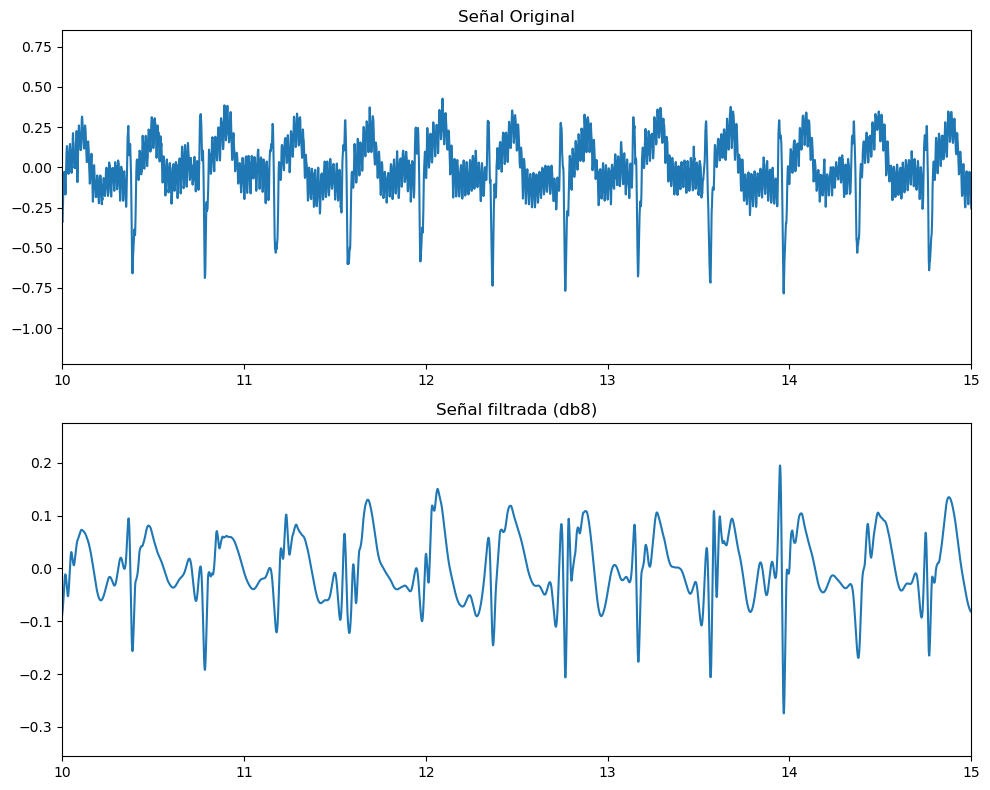

In [559]:
import pywt
import matplotlib.pyplot as plt

# Realizar la descomposición en wavelets
coeffs = pywt.wavedec(y_1, 'db8', level=8)

# Establecer un umbral para el denoising
umbral = 0.8

# Aplicar el umbral a los coeficientes
coeffs_umbral = [pywt.threshold(c, umbral, mode='soft') for c in coeffs]

# Reconstruir la señal denoised
senal_denoised = pywt.waverec(coeffs_umbral, 'db8')

plt.figure(figsize=(10, 8))

plt.subplot(2, 1, 1)
plt.xlim(10,15)
plt.plot(t_1, y_1, label='Señal Original')
plt.title('Señal Original')

plt.subplot(2, 1, 2)
plt.plot(t_1, senal_denoised, label='Señal Denoised')
plt.xlim(10,15)
plt.title('Señal filtrada (db8)')

plt.tight_layout()
plt.show()

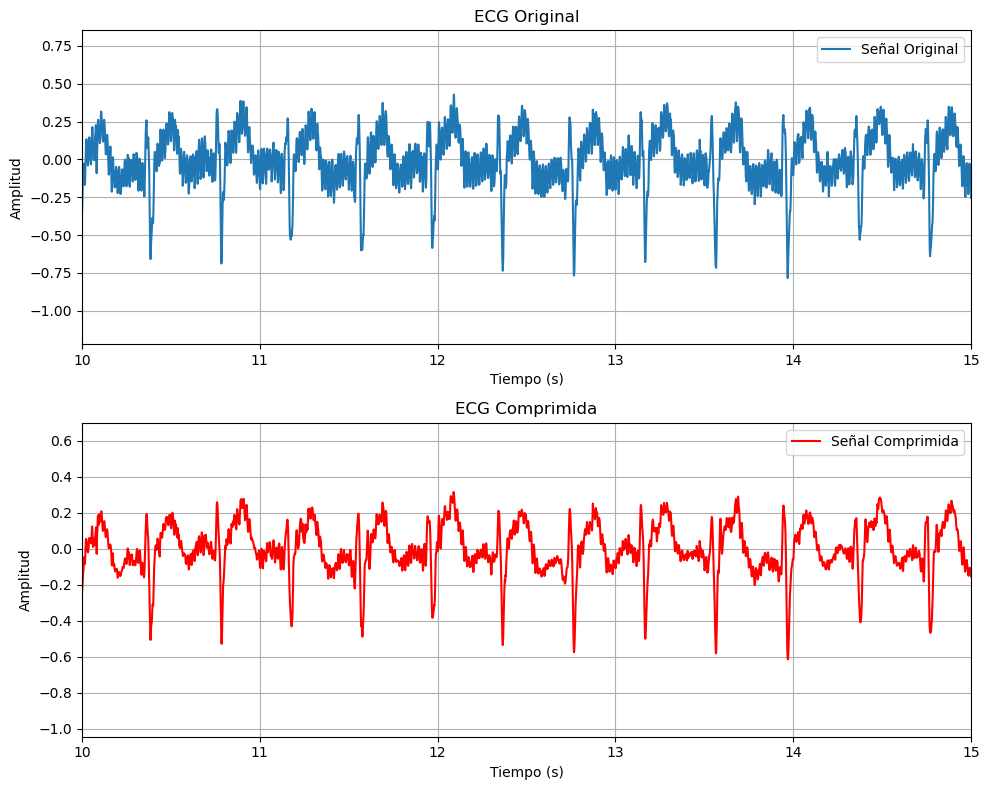

In [560]:
import pywt
import numpy as np
import matplotlib.pyplot as plt


coeffs = pywt.wavedec(y_1, wavelet, level=8)

coeffs_umbral = [coeffs[0]]  
for i in range(1, len(coeffs)):
    umbral = 0.1 * np.max(np.abs(coeffs[i]))
    cD = pywt.threshold(coeffs[i], umbral, mode='soft')
    coeffs_umbral.append(cD)

senal_comprimida = pywt.waverec(coeffs_umbral, wavelet)

t_2 = np.linspace(0, len(y_1)/Fs, len(senal_comprimida))

plt.figure(figsize=(10, 8))

# Señal original
plt.subplot(2,1,1)
plt.plot(t_1, y_1, label='Señal Original')
plt.xlim(10, 15)  
plt.title('ECG Original')
plt.xlabel('Tiempo (s)')
plt.ylabel('Amplitud')
plt.grid(True)
plt.legend()

# Señal comprimida
plt.subplot(2,1,2)
plt.plot(t_2, senal_comprimida, color='red', label='Señal Comprimida')
plt.xlim(10, 15)
plt.title('ECG Comprimida')
plt.xlabel('Tiempo (s)')
plt.ylabel('Amplitud')
plt.grid(True)
plt.legend()

plt.tight_layout()
plt.show()
